# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

1. [ПОДГОТОВКА ДАННЫХ](#shag_1)

а) [обработка пропущенных значений](#shag_1_1)

б) [ОНЕ](#shag_1_2)

2. [ОБУЧЕНИЕ МОДЕЛЕЙ](#shag_2)

3. [АНАЛИЗ МОДЕЛЕЙ](#shag_3)


<a id='shag_1'></a>

## Подготовка данных

In [1]:
#pip install hpsklearn

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from pandas import DataFrame
import timeit

In [3]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


Поскольку цель - уметь предсказывать цену для автомобиля перед подачей объявления, уберем лишние признаки, такие как: DateCrawled — дата скачивания анкеты из базы
RegistrationYear — год регистрации автомобиля
RegistrationMonth — месяц регистрации автомобиля
DateCreated — дата создания анкеты
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя

In [5]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [6]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
NumberOfPictures    354369 non-null int64
dtypes: int64(5), object(6)
memory usage: 29.7+ MB
None
               Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%  

<a id='vibros'></a>

Обратми внимание, что минимальные значения по цене, мощности и году регистрации составляют: 0, 0 и 1000, что говорит об ошибке. Максимальные значения года регистрации и мощности: 9999 и 20000. Проанализируем выбросы и избавимся от них

Text(0.5, 0, 'Цена')

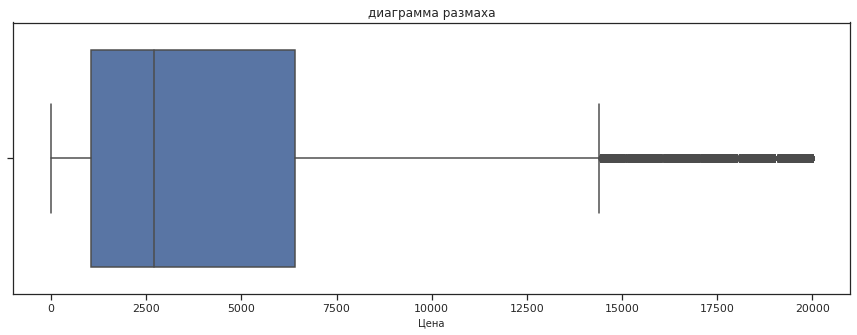

In [7]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='Price')
plt.title('диаграмма размаха', fontsize=12)
plt.xlabel('Цена', fontsize=10)

In [8]:
df.loc[df['Price']>140000] = np.NaN

Text(0.5, 0, 'Год регистрации')

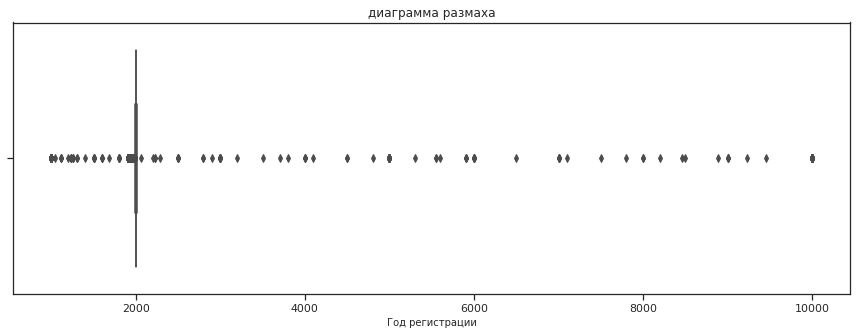

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='RegistrationYear')
plt.title('диаграмма размаха', fontsize=12)
plt.xlabel('Год регистрации', fontsize=10)

In [10]:
df.loc[df['RegistrationYear']>2021] = np.NaN
df.loc[df['RegistrationYear']<1960] = np.NaN

Text(0.5, 0, 'Мощность')

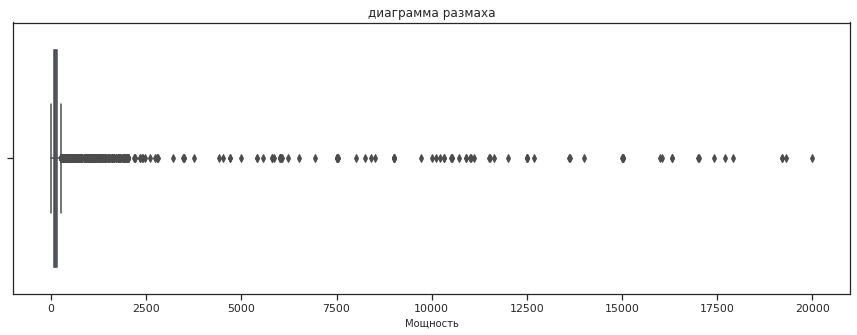

In [11]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='Power')
plt.title('диаграмма размаха', fontsize=12)
plt.xlabel('Мощность', fontsize=10)

In [12]:
df.loc[df['Power']>500] = np.NaN

<a id='data2'></a>

Кроме датафрейма с заменой пропущенных значений подготовим альтернативный датафрейм с удалением таких строк.

In [13]:
data2=df.dropna()

In [14]:
print(df.isna().sum())

Price                 971
VehicleType         38154
RegistrationYear      971
Gearbox             20512
Power                 971
Model               20386
Kilometer             971
FuelType            33536
Brand                 971
NotRepaired         71647
NumberOfPictures      971
dtype: int64


<a id='shag_1_1'></a>

Пропущенные значения 'VehicleType', 'Gearbox', 'FuelType' заполним в зависимости от самых распространенных значений для соответствующих моделей авто. Аналогично заполним нулевые значения 'Power'.
Пропущенные значения 'Model' придется удалить, т.к. от модели может очень сильно зависеть цена, и неверное заполнение значений может сильно ухудшить 
Пропущенные значения NotRepaired заполним в соответствующей вероятности от значения в общей выборке.

In [15]:
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480.0,NaN,1993.0,manual,0.0,golf,150000.0,petrol,volkswagen,NaN,0.0
1,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,gasoline,audi,yes,0.0
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,gasoline,jeep,NaN,0.0
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,gasoline,skoda,no,0.0


Заполним пропуски

In [16]:
display(df.head(16))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480.0,NaN,1993.0,manual,0.0,golf,150000.0,petrol,volkswagen,NaN,0.0
1,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,gasoline,audi,yes,0.0
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,gasoline,jeep,NaN,0.0
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,gasoline,skoda,no,0.0
5,650.0,sedan,1995.0,manual,102.0,3er,150000.0,petrol,bmw,yes,0.0
6,2200.0,convertible,2004.0,manual,109.0,2_reihe,150000.0,petrol,peugeot,no,0.0
7,0.0,sedan,1980.0,manual,50.0,other,40000.0,petrol,volkswagen,no,0.0
8,14500.0,bus,2014.0,manual,125.0,c_max,30000.0,petrol,ford,NaN,0.0
9,999.0,small,1998.0,manual,101.0,golf,150000.0,NaN,volkswagen,NaN,0.0


Пропущенные значения VehicleType,	Gearbox,	Power	 заменим в зависимости от значения Model.

In [17]:
print(df['Kilometer'].describe())

count    353398.000000
mean     128337.582556
std       37731.707626
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


In [18]:
median = df['Kilometer'].median()
df['Kilometer'].fillna(median, inplace=True)

In [19]:
df_select = df.groupby(['Model','VehicleType','Power','Gearbox','FuelType']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
df_select.rename_axis('index').reset_index()
df_select = df_select.drop_duplicates(['Model'])
print(df_select)

                    Model  VehicleType  Power Gearbox  FuelType  counts
11930                golf        sedan   75.0  manual    petrol    3005
19118                polo        small   60.0  manual    petrol    2077
9093                corsa        small   60.0  manual    petrol    1514
22121              twingo        small   58.0  manual    petrol    1476
10513              fiesta        small   60.0  manual    petrol    1139
...                   ...          ...    ...     ...       ...     ...
20100              samara        wagon    0.0  manual    petrol       2
19683  range_rover_evoque          suv  296.0    auto  gasoline       2
20452             serie_1        wagon    0.0  manual  gasoline       1
19691          rangerover          suv    0.0  manual  gasoline       1
12588                  i3  convertible  170.0    auto    petrol       1

[250 rows x 6 columns]


In [20]:
model_list = list(df_select['Model'])
print(model_list)

['golf', 'polo', 'corsa', 'twingo', 'fiesta', 'punto', 'ka', 'lupo', 'passat', 'clio', 'transporter', '3er', '2_reihe', 'c_klasse', 'touran', 'astra', 'focus', 'a4', 'arosa', 'fortwo', '5er', '1er', 'a3', 'fox', 'vectra', 'mx_reihe', '80', 'a6', 'a_klasse', 'ibiza', 'mondeo', 'other', '500', '1_reihe', 'aygo', 'cooper', 'micra', 'zafira', 'seicento', 'one', 'c1', 'e_klasse', 'sharan', 'slk', 'octavia', '3_reihe', 'scenic', 'swift', 'clk', 'a1', 'fabia', 'picanto', 'm_klasse', 'tiguan', 'tigra', 'leon', 'panda', 'omega', 'civic', 'up', 'scirocco', 'yaris', 'galaxy', 'tt', 's_max', 'caddy', 'colt', 'meriva', 'a2', 'kangoo', 'matiz', 'touareg', 'x_reihe', 'i_reihe', 'kuga', 'insignia', 'megane', 'b_klasse', 'c2', 'sandero', 'eos', '5_reihe', '147', 'berlingo', 'escort', 'tucson', 'stilo', 'alhambra', 'carisma', 'bora', 'a8', 'c_max', 'avensis', 'laguna', 'v50', 'sprinter', '6_reihe', 'beetle', 'roadster', 'jimny', 'agila', 'c3', 'v40', 'getz', 'x_trail', 'z_reihe', 'ypsilon', 'vito', 'xc_

In [21]:
change_list = ['VehicleType', 'Gearbox', 'FuelType']

In [22]:
for column_name in change_list:
    for model in model_list:
        result_df = df_select.loc[df_select['Model']==model,column_name].reset_index()
        df.loc[df[column_name].isna()&(df['Model']==model),column_name]=result_df[column_name][0]

In [23]:
for model in model_list:
    result_df = df_select.loc[df_select['Model']==model,'Power'].reset_index()
    df.loc[(df['Power']==0)&(df['Model']==model),'Power']=result_df['Power'][0]

In [24]:
print(df['NotRepaired'].value_counts())

no     246789
yes     35933
Name: NotRepaired, dtype: int64


Подавляющее большинство значений NotRepaired = no. Заполним соответствующе.

In [25]:
df.loc[df['NotRepaired'].isna(),'NotRepaired']='no'

In [26]:
df=df.dropna()
print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333983 entries, 0 to 354368
Data columns (total 11 columns):
Price               333983 non-null float64
VehicleType         333983 non-null object
RegistrationYear    333983 non-null float64
Gearbox             333983 non-null object
Power               333983 non-null float64
Model               333983 non-null object
Kilometer           333983 non-null float64
FuelType            333983 non-null object
Brand               333983 non-null object
NotRepaired         333983 non-null object
NumberOfPictures    333983 non-null float64
dtypes: float64(5), object(6)
memory usage: 30.6+ MB
None
         Price  VehicleType  RegistrationYear Gearbox  Power        Model  \
0        480.0        sedan            1993.0  manual   75.0         golf   
2       9800.0          suv            2004.0    auto  163.0        grand   
3       1500.0        small            2001.0  manual   75.0         golf   
4       3600.0        small            2008.0

<a id='shag_1_2'></a>

Сделаем масштабирование. Обработка ОНЕ + для Model и Brand, у которых много значений, попробуем обработать ordinal-ом. 

In [27]:
print(df.dtypes)

Price               float64
VehicleType          object
RegistrationYear    float64
Gearbox              object
Power               float64
Model                object
Kilometer           float64
FuelType             object
Brand                object
NotRepaired          object
NumberOfPictures    float64
dtype: object


In [28]:
print(df['VehicleType'].value_counts())

sedan          100703
small           87098
wagon           65786
bus             30858
convertible     19541
coupe           15574
suv             11652
other            2771
Name: VehicleType, dtype: int64


In [29]:
print(df['Brand'].value_counts())

volkswagen       73386
opel             37957
bmw              34915
mercedes_benz    30773
audi             28129
ford             24112
renault          17162
peugeot          10095
fiat              9111
seat              6661
skoda             5353
mazda             5261
smart             4973
citroen           4873
nissan            4729
toyota            4444
hyundai           3356
mini              3136
volvo             3094
mitsubishi        2856
honda             2660
kia               2350
suzuki            2184
alfa_romeo        2170
chevrolet         1626
chrysler          1344
dacia              877
daihatsu           767
subaru             716
porsche            704
jeep               638
land_rover         531
saab               509
daewoo             495
trabant            488
jaguar             488
lancia             446
rover              404
lada               210
Name: Brand, dtype: int64


In [30]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
ord_columns = ['Model', 'Brand']


In [31]:
df_ohe = pd.get_dummies(df.loc[:, ohe_columns], drop_first=True)
df_ohe = pd.get_dummies(df_ohe, drop_first=False)
display(df.head())
print(df.shape)
display(df_ohe.head())
print(df_ohe.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480.0,sedan,1993.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,gasoline,jeep,no,0.0
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,gasoline,skoda,no,0.0
5,650.0,sedan,1995.0,manual,102.0,3er,150000.0,petrol,bmw,yes,0.0


(333983, 11)


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1


(333983, 15)


In [32]:
data2_ohe = pd.get_dummies(data2.loc[:, ohe_columns], drop_first=True)
data2_ohe = pd.get_dummies(data2_ohe, drop_first=False)

In [33]:
encoder = OrdinalEncoder()
df_ord = pd.DataFrame(encoder.fit_transform(df.loc[:, ord_columns]), )
display(df_ord.head())
print(df_ord.shape)

,0,1
0,116.0,37.0
1,117.0,14.0
2,116.0,37.0
3,101.0,31.0
4,11.0,2.0


(333983, 2)


In [34]:
encoder = OrdinalEncoder()
data2_ord = pd.DataFrame(encoder.fit_transform(data2.loc[:, ord_columns]), )
data2 = data2.drop(columns=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired','Model', 'Brand'])
print(data2_ord.head())

       0     1
0  116.0  37.0
1  101.0  31.0
2   11.0   2.0
3    8.0  25.0
4  166.0  37.0


In [35]:
print(df_ord.isnull().sum())

0    0
1    0
dtype: int64


In [36]:
display(df.head())
df = df.drop(columns=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired','Model', 'Brand'])
display(df.head())
print(df.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480.0,sedan,1993.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,gasoline,jeep,no,0.0
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,gasoline,skoda,no,0.0
5,650.0,sedan,1995.0,manual,102.0,3er,150000.0,petrol,bmw,yes,0.0


,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
0,480.0,1993.0,75.0,150000.0,0.0
2,9800.0,2004.0,163.0,125000.0,0.0
3,1500.0,2001.0,75.0,150000.0,0.0
4,3600.0,2008.0,69.0,90000.0,0.0
5,650.0,1995.0,102.0,150000.0,0.0


(333983, 5)


Объединим наш основной датафрейм с закодированными данными.

In [37]:
# Объединим полученные датафреймы в единый:
df.reset_index(drop=True, inplace=True)
df['0']=df_ord[0]
df['1']=df_ord[1]
df_ohe.reset_index(drop=True, inplace=True)
df = df.join([df_ohe])
display(df.head())
print(df.shape)

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures,0,1,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,480.0,1993.0,75.0,150000.0,0.0,116.0,37.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,9800.0,2004.0,163.0,125000.0,0.0,117.0,14.0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1500.0,2001.0,75.0,150000.0,0.0,116.0,37.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,3600.0,2008.0,69.0,90000.0,0.0,101.0,31.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,650.0,1995.0,102.0,150000.0,0.0,11.0,2.0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


(333983, 22)


In [38]:
data2.reset_index(drop=True, inplace=True)
data2['0']=data2_ord[0]
data2['1']=data2_ord[1]
data2_ohe.reset_index(drop=True, inplace=True)
data2 = data2.join([data2_ohe])

scaler = MinMaxScaler()
data2[['Power','Kilometer']] = scaler.fit_transform(data2[['Power','Kilometer']])
display(data2.head())
print(data2.shape)

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures,0,1,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,1500.0,2001.0,0.150,1.000000,0.0,116.0,37.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,3600.0,2008.0,0.138,0.586207,0.0,101.0,31.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,650.0,1995.0,0.204,1.000000,0.0,11.0,2.0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,2200.0,2004.0,0.218,1.000000,0.0,8.0,25.0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,1980.0,0.100,0.241379,0.0,166.0,37.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


(245530, 22)


In [39]:
print(df.isnull().sum())

Price                      0
RegistrationYear           0
Power                      0
Kilometer                  0
NumberOfPictures           0
0                          0
1                          0
VehicleType_convertible    0
VehicleType_coupe          0
VehicleType_other          0
VehicleType_sedan          0
VehicleType_small          0
VehicleType_suv            0
VehicleType_wagon          0
Gearbox_manual             0
FuelType_electric          0
FuelType_gasoline          0
FuelType_hybrid            0
FuelType_lpg               0
FuelType_other             0
FuelType_petrol            0
NotRepaired_yes            0
dtype: int64


Осталось масштабировать признаки, чтобы такие признаки, как пробег, не превышали многократно остальные.

In [40]:
data = df
scaler = MinMaxScaler()
data[['Power','Kilometer']] = scaler.fit_transform(data[['Power','Kilometer']])

print(data)

         Price  RegistrationYear  Power  Kilometer  NumberOfPictures      0  \
0        480.0            1993.0  0.150   1.000000               0.0  116.0   
1       9800.0            2004.0  0.326   0.827586               0.0  117.0   
2       1500.0            2001.0  0.150   1.000000               0.0  116.0   
3       3600.0            2008.0  0.138   0.586207               0.0  101.0   
4        650.0            1995.0  0.204   1.000000               0.0   11.0   
...        ...               ...    ...        ...               ...    ...   
333978  1150.0            2000.0  0.250   1.000000               0.0  249.0   
333979     0.0            2005.0  0.150   1.000000               0.0   78.0   
333980  1199.0            2000.0  0.202   0.827586               0.0  106.0   
333981  9200.0            1996.0  0.204   1.000000               0.0  224.0   
333982  3400.0            2002.0  0.200   1.000000               0.0  116.0   

           1  VehicleType_convertible  VehicleType_

<div class="alert alert-info"> Проведена замена аномалий на NaN с последующей обработкой прпоущенных значений, а также с удалением всех пропущенных значений на альтернативном датафрейме. </div>

1) [Работа с аномалиями](#vibros)
2) [Альтернативный датафрейм](#data2)

<a id='shag_2'></a>

## Обучение моделей

In [41]:
#data = data.head(10000)
x = data.drop('Price', axis=1)
y = data['Price']
print(x.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.85, random_state=123)

(333983, 21) (333983,)


In [42]:
#data = data.head(10000)
x2 = data2.drop('Price', axis=1)
y2 = data2['Price']
print(x2.shape, y2.shape)

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2,  test_size=0.85, random_state=123)

(245530, 21) (245530,)


In [43]:
df_TestModels = pd.DataFrame()

### Модель линейной регрессии

In [44]:
%time
start_time = timeit.default_timer()
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model,parameters, cv=3,verbose=3)
grid.fit(x_train, y_train)
RMSE = np.sqrt(((grid.predict(x_test) - y_test) ** 2).mean())
print("RMSE: %.2f" % RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.548, total=   0.0s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. fit_intercept=True, normalize=True, score=0.558, total=   0.1s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.564, total=   0.2s
[CV] fit_intercept=True, normalize=False .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] . fit_intercept=True, normalize=False, score=0.548, total=   0.2s
[CV] fit_intercept=True, normalize=False .............................
[CV] . fit_intercept=True, normalize=False, score=0.558, total=   0.2s
[CV] fit_intercept=True, normalize=False .............................
[CV] . fit_intercept=True, normalize=False, score=0.564, total=   0.2s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.500, total=   0.2s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.506, total=   0.2s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.514, total=   0.2s
[CV] fit_intercept=False, normalize=False ............................
[CV]  fit_intercept=False, normalize=False, score=0.500, total=   0.2s
[CV] fit_intercept=False, normalize=False ............................
[CV]  

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.3s finished


RMSE: 3027.03
2.644628024660051


Wall time: 5.48 µs
RMSE: 3027.03

In [45]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date1']])
df_TestModels = df_TestModels.append(tmp)

In [46]:
%time
start_time = timeit.default_timer()
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model,parameters, cv=3,verbose=3)
grid.fit(x2_train, y2_train)
#print ("r2 / variance : ", grid.best_score_)
print("RMSE: %.2f" % np.sqrt(((grid.predict(x2_test) - y2_test) ** 2).mean()))
elapsed = timeit.default_timer() - start_time
print(elapsed)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.614, total=   0.0s
[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.615, total=   0.2s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .. fit_intercept=True, normalize=True, score=0.624, total=   0.2s
[CV] fit_intercept=True, normalize=False .............................
[CV] . fit_intercept=True, normalize=False, score=0.614, total=   0.2s
[CV] fit_intercept=True, normalize=False .............................
[CV] . fit_intercept=True, normalize=False, score=0.615, total=   0.2s
[CV] fit_intercept=True, normalize=False .............................
[CV] . fit_intercept=True, normalize=False, score=0.624, total=   0.2s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.546, total=   0.3s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.550, total=   0.2s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.553, total=   0.2s
[CV] fit_intercept=False, normalize=False ............................
[CV]  

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.4s finished


RMSE: 2909.26
2.6962619787082076


Результаты модели на альтернативном датафрейме оказались лучше:
Wall time: 5.48 µs
RMSE: 2909.26    

In [47]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date2']])
df_TestModels = df_TestModels.append(tmp)

In [48]:
%%time
start_time = timeit.default_timer()
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
#print("r2/variance: ", model.score(x_test,y_test))
print("RMSE: %.2f" % np.sqrt(((model.predict(x_test) - y_test) ** 2).mean()))
elapsed = timeit.default_timer() - start_time
print(elapsed)

RMSE: 3027.03
0.49748309049755335
CPU times: user 216 ms, sys: 295 ms, total: 511 ms
Wall time: 498 ms


RMSE: 3564.66
CPU times: user 220 ms, sys: 242 ms, total: 462 ms
Wall time: 413 ms

In [49]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date1']])
df_TestModels = df_TestModels.append(tmp)

### Проверка на адекватность

In [50]:
%%time
start_time = timeit.default_timer()
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(x_train,y_train) 
predict_test = dummy_clf.predict(x_test)
RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
print('RMSE=', RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

RMSE= 6390.294219182217
0.0940582538023591
CPU times: user 20.9 ms, sys: 16.4 ms, total: 37.3 ms
Wall time: 94.2 ms


In [51]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date1']])
df_TestModels = df_TestModels.append(tmp)

RMSE= 6388.4298108989815
CPU times: user 13.1 ms, sys: 17 µs, total: 13.1 ms
Wall time: 15.1 ms

In [52]:
%%time
start_time = timeit.default_timer()
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(x2_train,y2_train) 
predict_test = dummy_clf.predict(x2_test)
RMSE = np.sqrt(((predict_test - y2_test) ** 2).mean())
print('RMSE=', RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

RMSE= 5937.866657969617
0.0063303615897893906
CPU times: user 6.89 ms, sys: 0 ns, total: 6.89 ms
Wall time: 6.4 ms


In [53]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date2']])
df_TestModels = df_TestModels.append(tmp)

### model LGBM

In [54]:
%%time
best_RMSE = 10000
best_n_estimators = 0
best_m_depth = 0
for maxdepth in range(1, 16, 5):
    for nestimators in range(1, 100, 35):
        start_time = timeit.default_timer()
        model = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                    learning_rate=0.17, n_estimators=nestimators, max_depth=maxdepth,
                                    metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
        model.fit(x_train, y_train) 
        predict_test = model.predict(x_test)
        RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_n_estimators = n_estimators
            best_m_depth = max_depth
    print(model,': ',RMSE)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
print('best_RMSE =', RMSE,'best_n_estimators =', n_estimators,  'best_m_depth =', max_depth)

NameError: name 'n_estimators' is not defined

In [55]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date1']])
df_TestModels = df_TestModels.append(tmp)

### SVR

In [56]:
%%time
start_time = timeit.default_timer()
model = SVR(kernel='linear')
model.fit(x_train, y_train) 
predict_test = model.predict(x_test)
RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
print(model,': ',RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) :  3789.1415003840375
393.8748297346756
CPU times: user 6min 33s, sys: 385 ms, total: 6min 33s
Wall time: 6min 33s


Wall time: 6min 29s
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) :  3789.1415003840375

In [57]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date1']])
df_TestModels = df_TestModels.append(tmp)

In [58]:
%%time
start_time = timeit.default_timer()
model = SVR(kernel='linear')
model.fit(x2_train, y2_train) 
predict_test = model.predict(x2_test)
RMSE = np.sqrt(((predict_test - y2_test) ** 2).mean())
print(model,': ',RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) :  3598.206500208032
212.7836989192292
CPU times: user 3min 32s, sys: 229 ms, total: 3min 32s
Wall time: 3min 32s


In [59]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date2']])
df_TestModels = df_TestModels.append(tmp)

### KNeighborsRegressor

In [60]:
%%time
start_time = timeit.default_timer()
model = KNeighborsRegressor(n_neighbors=6)
model.fit(x_train, y_train) 
predict_test = model.predict(x_test)
RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
print(model,': ',RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform') :  2122.94501373304
8.314380896277726
CPU times: user 8.21 s, sys: 99.9 ms, total: 8.31 s
Wall time: 8.31 s


Wall time: 7.81 s
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform') :  2122.94501373304

In [61]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date1']])
df_TestModels = df_TestModels.append(tmp)

In [62]:
%%time
start_time = timeit.default_timer()
model = KNeighborsRegressor(n_neighbors=6)
model.fit(x2_train, y2_train) 
predict_test = model.predict(x2_test)
RMSE = np.sqrt(((predict_test - y2_test) ** 2).mean())
print(model,': ',RMSE)
elapsed = timeit.default_timer() - start_time
print(elapsed)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform') :  2030.379338848077
5.222069791518152
CPU times: user 5.14 s, sys: 75.9 ms, total: 5.21 s
Wall time: 5.22 s


In [63]:
tmp = pd.DataFrame([[model, elapsed, RMSE, 'date2']])
df_TestModels = df_TestModels.append(tmp)

<a id='shag_3'></a>

## Анализ моделей

In [65]:
display(df_TestModels)

,0,1,2,3
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",2.644628,3027.029916,date1
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",2.696262,3027.029916,date2
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.497483,3027.029916,date1
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.094058,6390.294219,date1
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.006330,5937.866658,date2
0,"LGBMRegressor(bagging_fraction=0.8, boosting_t...",0.006330,4305.947244,date1
0,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",393.874830,3789.141500,date1
0,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",212.783699,3598.206500,date2
0,"KNeighborsRegressor(algorithm='auto', leaf_siz...",8.314381,2122.945014,date1
0,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5.222070,2030.379339,date2


Лучше всего себя показала модель KNeighborsRegressor (RMSE 2030.379339, time 5.222070). Можно также заметить, что в качество моделей на альтернативном датафрейме date2 немного лучше, чем на основном date1. Т.е. в данном случае удаление пропущенных значений более целесообразно.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей